In [15]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.autograd.functional import hessian, jacobian

def minibatch(N, M):
    """Splits data set x into M roughly equally minibatches. If not evenly divisible, the excess
    is evenly spread throughout some of the batches.

    Args:
        N (Int): Number of datapoints
        M (Int): Number of minibatches

    Returns:
        Array: [M,.]-dim array containing the minibatch indices
    """
    indices = np.random.permutation(N)  # random permutation of [0, ..., len(x)-1]
    indices = np.array_split(indices, M)  # Split permutation into M sub-arrays
    return indices

In [2]:
dtype = torch.float
#device = torch.device("cuda:0")
device = torch.device("cpu")

# Number of points to train on
num_points = 100

# normalized time domain for ODE
t = torch.linspace(0, 2, num_points, device=device, dtype=dtype, requires_grad=True).reshape(-1,1)

# Make a random symetric + real matrix
Q = torch.randn(6,6, device=device, dtype=dtype, requires_grad=False)
A = torch.transpose(Q, 0, 1) + Q 
A.requires_grad = True

# Initial guess for the eigenvalue
v0 = torch.randn(A.size(0), device=device, dtype=dtype, requires_grad=False).reshape(-1,1)
#eigval, eigvec = np.linalg.eigh(A.detach().numpy())
#v0 = torch.from_numpy(eigvec[:, -1]).reshape(-1,1)


# Trial solution to ODE
def f_trial(t, N):
    return v0 * torch.exp(-t) + (1 - torch.exp(-t)) * N

# Shape of network
input_dim = 1
hidden_neurons = 50
output_dim = v0.size(0)

# Create random Tensors for weights.
w1 = torch.randn(input_dim, hidden_neurons, device=device, dtype=dtype, requires_grad=True)
w2 = torch.randn(hidden_neurons, output_dim, device=device, dtype=dtype, requires_grad=True)

In [3]:
print(v0)

tensor([[-1.0051],
        [-1.4424],
        [ 0.9942],
        [-0.0947],
        [-0.2244],
        [ 1.4754]])


In [4]:
#v0.transpose(0,1).mm(A).mm(v0)
v0_T = v0.transpose(0,1)
(- v0 + (v0_T.mm(v0) * A  + (1 - v0_T.mm(A).mm(v0)) * torch.eye(v0.size(0))).mm(v0))

tensor([[ -1.4858],
        [ -0.8893],
        [ 37.5641],
        [ 26.8056],
        [  4.3514],
        [-24.8116]], grad_fn=<AddBackward0>)

propose a trial solution to the ODE in the form
$$ 
    f_t(t, P) = v_0 \, e^{-t} + (1-e^{-t}) N(t,P)
$$
Where $N$ denotes the Neural Network, and $P$ its free parameters.

In [5]:
def costfunction(t, N, A, trial_func):
    loss = 0
    
    for i in range(t.size(0)):
        # Compute trial eigenvector & transpose
        v = trial_func(t[i], N[i])
        v_T = v.transpose(0,1)
       
        # Time derivative of trial function
        dfdt, dfdN = jacobian(trial_func, (t[i], N[i]), create_graph=True)  
        
        # right hand side of ODE
        RHS = (- v + (v_T.mm(v) * A  + (1 - v_T.mm(A).mm(v)) * torch.eye(v.size(0))).mm(v))
        
           # (-x_t + (x_t.T @ x_t * A + (1 - x_t.T @ A @ x_t) * np.identity(np.size(x_t,0))) @ x_t)
        
        # Increment the loss function
        loss = loss + (dfdt - RHS).pow(2).mean()
    
    return loss / t.size(0)

In [14]:
EPOCHS = 100

loss_arr = np.empty(EPOCHS, dtype=np.float)

learning_rate = 0.000002
for epoch in range(EPOCHS):
    N_output = torch.tanh(F.relu(t.mm(w1)).mm(w2))
        
    # Compute and print loss    
    loss = costfunction(t, N_output.reshape(-1,1), A, f_trial)
    
    loss_arr[epoch] = loss.detach().numpy()
    
    if epoch % 10 == 0:
        print(f"{epoch}: loss = ",loss)
    
    # Use autograd to compute the backward pass.
    loss.backward()

    # Update weights using gradient descent
    with torch.no_grad():
        w1 -= learning_rate * w1.grad
        w2 -= learning_rate * w2.grad
    
        # Manually zero the gradients after updating weights
        w1.grad.zero_()
        w2.grad.zero_()
        
plt.plot(loss_arr)
plt.xlabel("Epoch")
plt.ylabel("Loss")

0: loss =  tensor(48.7430, grad_fn=<DivBackward0>)
10: loss =  tensor(48.7400, grad_fn=<DivBackward0>)
20: loss =  tensor(48.7370, grad_fn=<DivBackward0>)
30: loss =  tensor(48.7340, grad_fn=<DivBackward0>)


KeyboardInterrupt: 

In [7]:
v_pred = f_trial(t[-1,:], N_output[-1,:].reshape(-1,1))

print("before norm: \n",v_pred)
v_pred = v_pred/v_pred.norm()
print("after norm: \n", v_pred)

eigval, eigvec = np.linalg.eigh(A.detach().numpy())
print(eigval)
print(eigvec)

print(eigvec[:,-1])

before norm: 
 tensor([[  2.0781],
        [ -3.5979],
        [ -6.3218],
        [-10.0004],
        [  3.3194],
        [ -8.1243]], grad_fn=<AddBackward0>)
after norm: 
 tensor([[ 0.1358],
        [-0.2351],
        [-0.4130],
        [-0.6534],
        [ 0.2169],
        [-0.5308]], grad_fn=<DivBackward0>)
[-4.0279174  -2.572797   -0.09391877  1.0403465   4.4998994   5.446228  ]
[[-0.39982182  0.1423625   0.15756835 -0.6663294   0.19133897 -0.5607515 ]
 [ 0.46825436  0.05622311  0.7951623   0.11360247 -0.20451418 -0.3009355 ]
 [ 0.26860863  0.44047344  0.19471665 -0.26167306  0.6171596   0.49654728]
 [-0.70073617 -0.05855672  0.53300583  0.13381305 -0.11553261  0.43610892]
 [-0.2038101   0.08366526  0.02999678  0.6517524   0.61056626 -0.39113864]
 [ 0.12712204 -0.8787072   0.14134909 -0.17871697  0.3931138   0.07249804]]
[-0.5607515  -0.3009355   0.49654728  0.43610892 -0.39113864  0.07249804]


In [8]:
eigval, eigvec = np.linalg.eigh(A.detach().numpy())
print(eigval)
print(eigvec)

[-4.0279174  -2.572797   -0.09391877  1.0403465   4.4998994   5.446228  ]
[[-0.39982182  0.1423625   0.15756835 -0.6663294   0.19133897 -0.5607515 ]
 [ 0.46825436  0.05622311  0.7951623   0.11360247 -0.20451418 -0.3009355 ]
 [ 0.26860863  0.44047344  0.19471665 -0.26167306  0.6171596   0.49654728]
 [-0.70073617 -0.05855672  0.53300583  0.13381305 -0.11553261  0.43610892]
 [-0.2038101   0.08366526  0.02999678  0.6517524   0.61056626 -0.39113864]
 [ 0.12712204 -0.8787072   0.14134909 -0.17871697  0.3931138   0.07249804]]


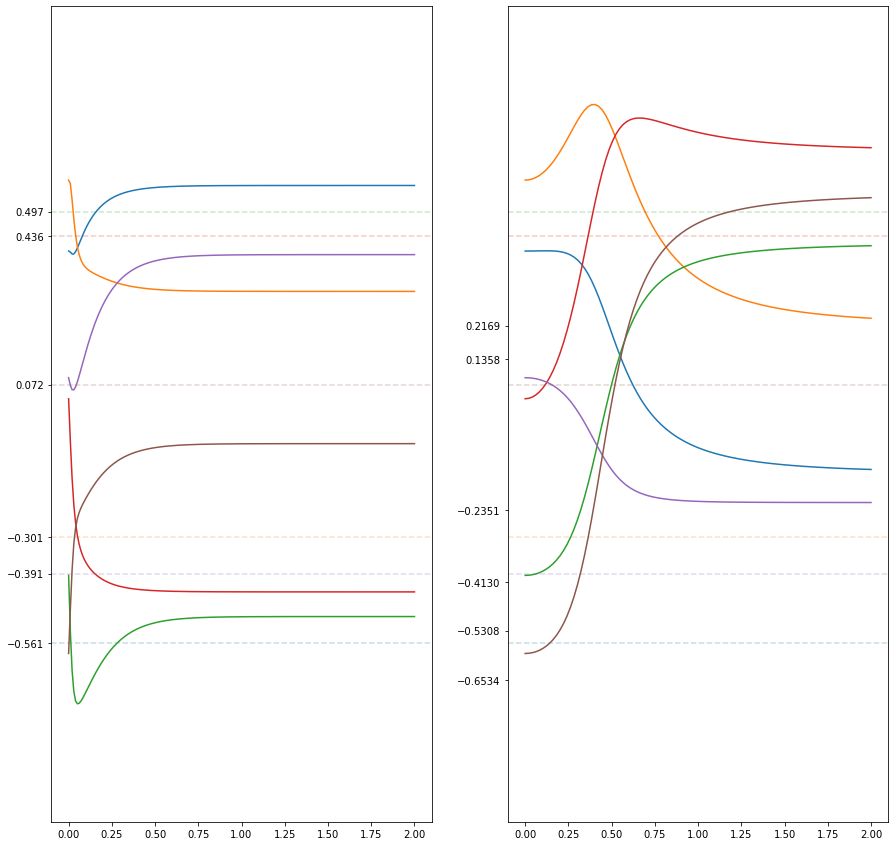

In [9]:
v_pred_np = np.zeros([t.size(0), 6])
for i in range(t.size(0)):
    ft = f_trial(t[i,:], N_output[i,:].reshape(-1,1)).detach().numpy().reshape(6)
    v_pred_np[i] = ft / np.sqrt(np.dot(ft, ft))

#Forward Euler for Yi et al diff.eq


x_t = v0.detach().numpy()
A_t = A.detach().numpy()
dt = 0.01
N = 200

time = np.linspace(0, dt * N, N)

#print(x_t/np.sqrt(x_t.T @ x_t)) # normalized eigenvector
#print(x_t.T @ A_t @ x_t / (x_t.T @ x_t)) # eigenvalue

x_euler = np.zeros([N, 6])


for i in range(N):
    x_euler[i, :] = x_t.reshape(6)
    x_euler[i, :] /= np.sqrt(np.dot(x_euler[i, :], x_euler[i, :]))
    x_t = x_t + (-x_t + (x_t.T @ x_t * A_t + (1 - x_t.T @ A_t @ x_t) * np.identity(6)) @ x_t)*dt
x_euler[N-1, :] = x_t.reshape(6)
x_euler[N-1, :] /= np.sqrt(np.dot(x_euler[i, :], x_euler[i, :]))
    

    
#print(x_t/np.sqrt(x_t.T @ x_t)) # normalized eigenvector
#print(x_t.T @ A_t @ x_t / (x_t.T @ x_t)) # eigenvalue

#print(eigvec[:,-1])

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]

plt.figure(figsize=(15, 15))
plt.subplot(121)
for d in range(6):
    plt.plot(time, -x_euler[:, d], color=colors[d])
    plt.axhline(eigvec[d, -1], alpha=0.25, color=colors[d], ls="--")
plt.yticks(x_euler[-1, :])
plt.ylim(-1,1)

plt.subplot(122)
for d in range(6):
    plt.plot(t.detach().numpy(), -v_pred_np[:, d], color=colors[d])
    plt.axhline(eigvec[d, -1], alpha=0.25, color=colors[d], ls="--")
plt.yticks(v_pred_np[-1, :])
plt.ylim(-1,1)

plt.show()

In [10]:
x_t = -v_pred_np[-1, :]
print(x_t.T @ A_t @ x_t / (x_t.T @ x_t))
eigval[-1]

1.8825341780467615


5.446228